# Spatial mapping of cell types across the mouse brain (3/3) - visualising results and downstream analysis

This notebook demonstrates how to use the **cell2location** model for mapping a single cell transcriptomic reference onto a spatial transcriptomic dataset. Here, we use a 10X single nucleus RNA-sequencing (snRNAseq) and Visium spatial transcriptomic data generated from adjacent tissue sections of the mouse brain ([Kleshchevnikov et al., BioRxiv 2020](https://www.biorxiv.org/content/10.1101/2020.11.15.378125v1)). 

cell2location is a Bayesian model that integrates single-cell RNA-seq (scRNA-seq) and multi-cell spatial transcriptomics to map cell types at scale (Fig below). cell2location leverages reference signatures that are estimated from scRNA-seq profiles, for example using conventional clustering followed by estimation of average gene expression profiles. Based on these reference signatures, mRNA contributions from each of the defined cell types are estimated at each location in the spatial data, which gives rise to both cell type proportions as well as absolute densities of cell types in a spatially resolved manner. In this notebook, we examine and use estimated cell abundances of cell types to perform downstream analysis. 

![Figure 1.](../images/Fig1_v2.png)  
***Figure 1.*** *Overview of the spatial mapping approach and the workflow which are enabled by cell2location. From left to right: Single-cell RNA-seq and spatial transcriptomics profiles are generated from the same tissue (1). Cell2location takes reference cell type signatures derived from scRNA-seq and spatial transcriptomics data as input (2, 3). The model then decomposes spatially resolved multi-cell RNA counts matrices into the reference signatures, thereby establishing a spatial mapping of cell types (4).*

## Outline

The [**cell2location** workflow](https://github.com/vitkl/cell2location_paper/blob/master/paper/FigS1_cell2location_workflow.pdf) consists of three sections:

I. Estimating reference expression signatures of cell types (1/3)

II. Spatially mapping cell types (2/3)

III. Results and downstream analysis (3/3, this notebook):

1. [Loading cell2location model output](#1.-Loading-cell2location-model-output)
2. [Visualisation of cell type locations](#2.-Visualisation-of-cell-type-locations)
3. [Automatic discrete region identification by clustering cell densities](#3.-Automatic-discrete-region-identification-by-clustering-cell-densities)
4. [Identify groups of co-located cell types using matrix factorisation (NMF)](#5.-Identify-co-occuring-cell-type-groups-using-matrix-factorisation)


## Loading packages

In [1]:
import sys
import pickle
import scanpy as sc
import anndata
import numpy as np
import os

import cell2location

import matplotlib as mpl
from matplotlib import pyplot as plt

# scanpy prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

## 1. Loading cell2location model output <a name="1.-Loading-cell2location-model-output"></a>

First, let's load the cell2location results. In the export step of cell2location pipeline, cell type abundances across locations are added to `sp_data` as columns of `sp_data.obs` and all paramters of the model are exported to `sp_data.uns['mod']`. This anndata object and a csv file `W.csv` / `W_q05.csv` with cell locations are saved to the results directory. 

Normally, you would have the output on your system (e.g. by running  tutorial 2/3), however, you could also start with the output from our data portal:

In [2]:
results_folder = './results/mouse_brain_snrna/'
r = {'run_name': 'LocationModelLinearDependentWMultiExperiment_2experiments_59clusters_5563locations_4006genes'}

# defining useful function
def select_slide(adata, s, s_col='sample'):
    r""" Select data for one slide from the spatial anndata object.
    
    :param adata: Anndata object with multiple spatial samples
    :param s: name of selected sample
    :param s_col: column in adata.obs listing sample name for each location
    """
    
    slide = adata[adata.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}
    
    return slide

In [3]:
if os.path.exists(f'{results_folder}{r["run_name"]}') is not True:
    os.mkdir('./results')
    os.mkdir(f'{results_folder}')
    os.system(f'cd {results_folder} && wget https://cell2location.cog.sanger.ac.uk/tutorial/mouse_brain_visium_results/{["run_name"]}.zip')
    os.system(f'cd {results_folder} && unzip {r["run_name"]}.zip')

We load the results of the model saved into the `adata_vis` Anndata object:

In [4]:
sp_data_file = results_folder +r['run_name']+'/sp.h5ad'

adata_vis = anndata.read(sp_data_file)

## 2. Visualisation of cell type locations <a name="2.-Visualisation-of-cell-type-locations"></a>

First, we learn how to visualise cell type locations using the standard scanpy plotting tool `sc.pl.spatial` and our custom tool that visualises several cell types in one figure using colour interpolation `cell2location.plt.mapping_video.plot_spatial`.

Cell2location estimates the absolute cell and mRNA abundance of reference cells types. For both of these measures, 5% quantile of the posterior distribution are used to visualise the results, representing the confident level of cell abundance and mRNA count.

For completeness, for each visium section, `sc.pl.spatial` was used to produce 4 figure panels showing the locations of all cell types (cell and mRNA abundance, 5% and the mean of the posterior distribution), saved to `r['run_name']/plots/spatial/`.

Here, we visualise locations of multiple cell types in one figure using absolute cell density (5% quantile), model parameter representing this is called `q05_spot_factors`. Six neuronal and glial cell types mapping to 6 distinct regions of the mouse brain are shown.

Trying to set attribute `.uns` of view, copying.


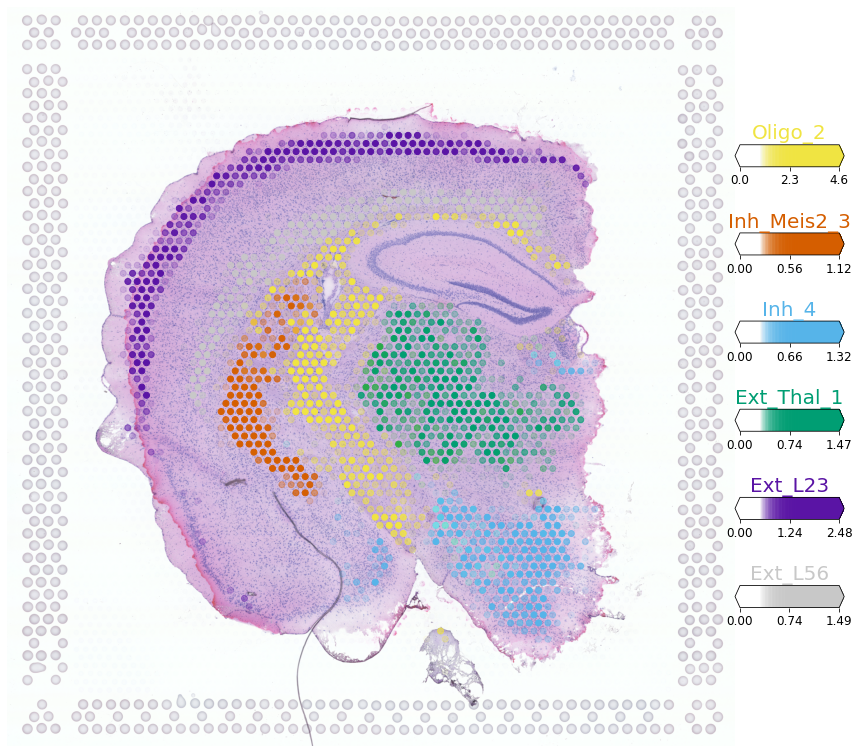

In [5]:
from cell2location.plt.mapping_video import plot_spatial

# select up to 6 clusters 
sel_clust = ['Oligo_2', 'Inh_Meis2_3', 'Inh_4', 'Ext_Thal_1', 'Ext_L23', 'Ext_L56']
sel_clust_col = ['q05_spot_factors' + str(i) for i in sel_clust]

slide = select_slide(adata_vis, 'ST8059048')

with mpl.rc_context({'figure.figsize': (15, 15)}):
    fig = plot_spatial(slide.obs[sel_clust_col], labels=sel_clust,
                  coords=slide.obsm['spatial'] \
                          * list(slide.uns['spatial'].values())[0]['scalefactors']['tissue_hires_scalef'], 
                  show_img=True, img_alpha=0.8,
                  style='fast', # fast or dark_background
                  img=list(slide.uns['spatial'].values())[0]['images']['hires'],
                  circle_diameter=6, colorbar_position='right')

We can produce this visualisation in dark background by setting `style='dark_background'` and hiding the image `img_alpha=0`.

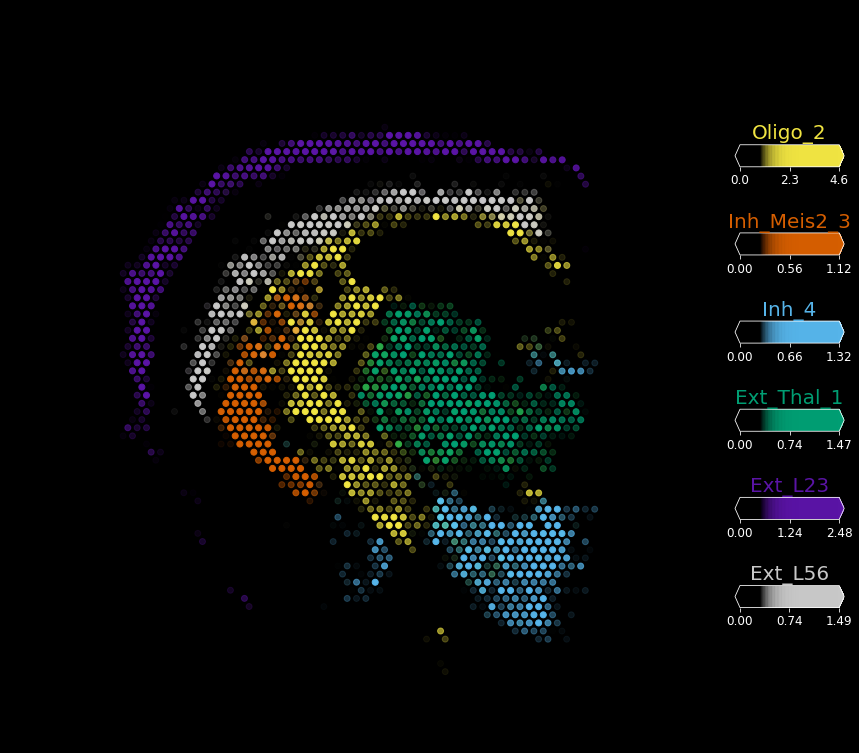

In [6]:
with mpl.rc_context({'figure.figsize': (15, 15)}):
    fig = plot_spatial(slide.obs[sel_clust_col], labels=sel_clust,
                  coords=slide.obsm['spatial'] \
                          * list(slide.uns['spatial'].values())[0]['scalefactors']['tissue_hires_scalef'], 
                  show_img=True, img_alpha=0,
                  style='dark_background', # fast or dark_background
                  img=list(slide.uns['spatial'].values())[0]['images']['hires'],
                  circle_diameter=6, colorbar_position='right')

Now, we compare the cell abundance estimates (above) to the estimated mRNA abundance from each cell type. This is often useful for indentifying which cell types did not map to a particular tissue (see [paper Fig S6](https://www.biorxiv.org/content/10.1101/2020.11.15.378125v1.supplementary-material), mRNA count < 50 - note max value on the color bars), model parameter representing this is called `q05_nUMI_factors`.

Trying to set attribute `.uns` of view, copying.


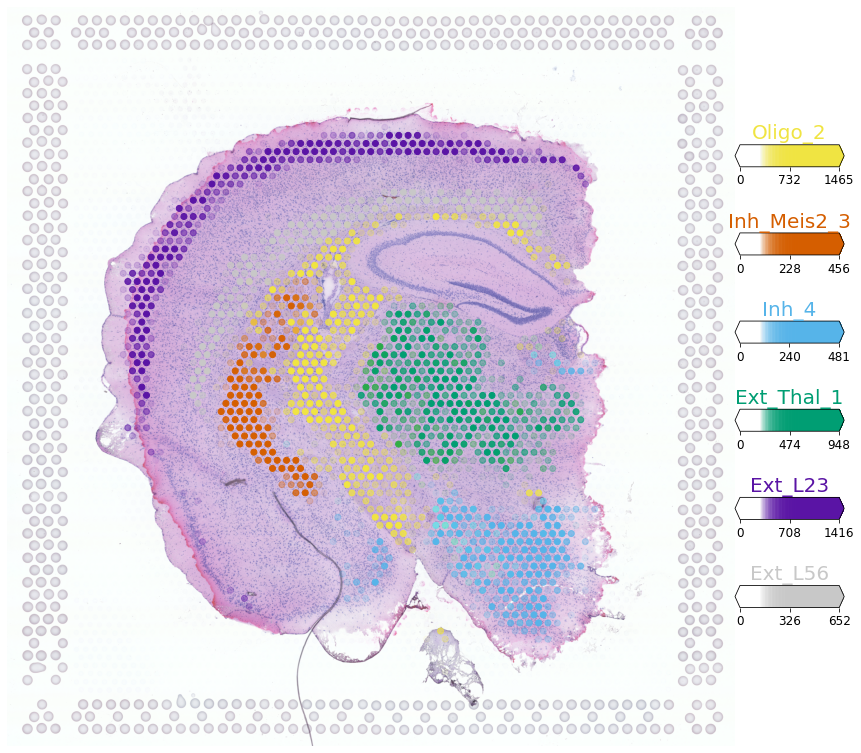

In [7]:
# select up to 6 clusters 
sel_clust = ['Oligo_2', 'Inh_Meis2_3', 'Inh_4', 'Ext_Thal_1', 'Ext_L23', 'Ext_L56']
sel_clust_col = ['q05_nUMI_factors' + str(i) for i in sel_clust]

slide = select_slide(adata_vis, 'ST8059048')

with mpl.rc_context({'figure.figsize': (15, 15)}):
    fig = plot_spatial(slide.obs[sel_clust_col], labels=sel_clust,
                  coords=slide.obsm['spatial'] \
                          * list(slide.uns['spatial'].values())[0]['scalefactors']['tissue_hires_scalef'], 
                  show_img=True, img_alpha=0.8,
                  img=list(slide.uns['spatial'].values())[0]['images']['hires'],
                  circle_diameter=6,  colorbar_position='right')

Next, we show how to use the standard scanpy pipeline to plot cell locations over histology images (for more extensive information refer to scanpy):

Trying to set attribute `.uns` of view, copying.


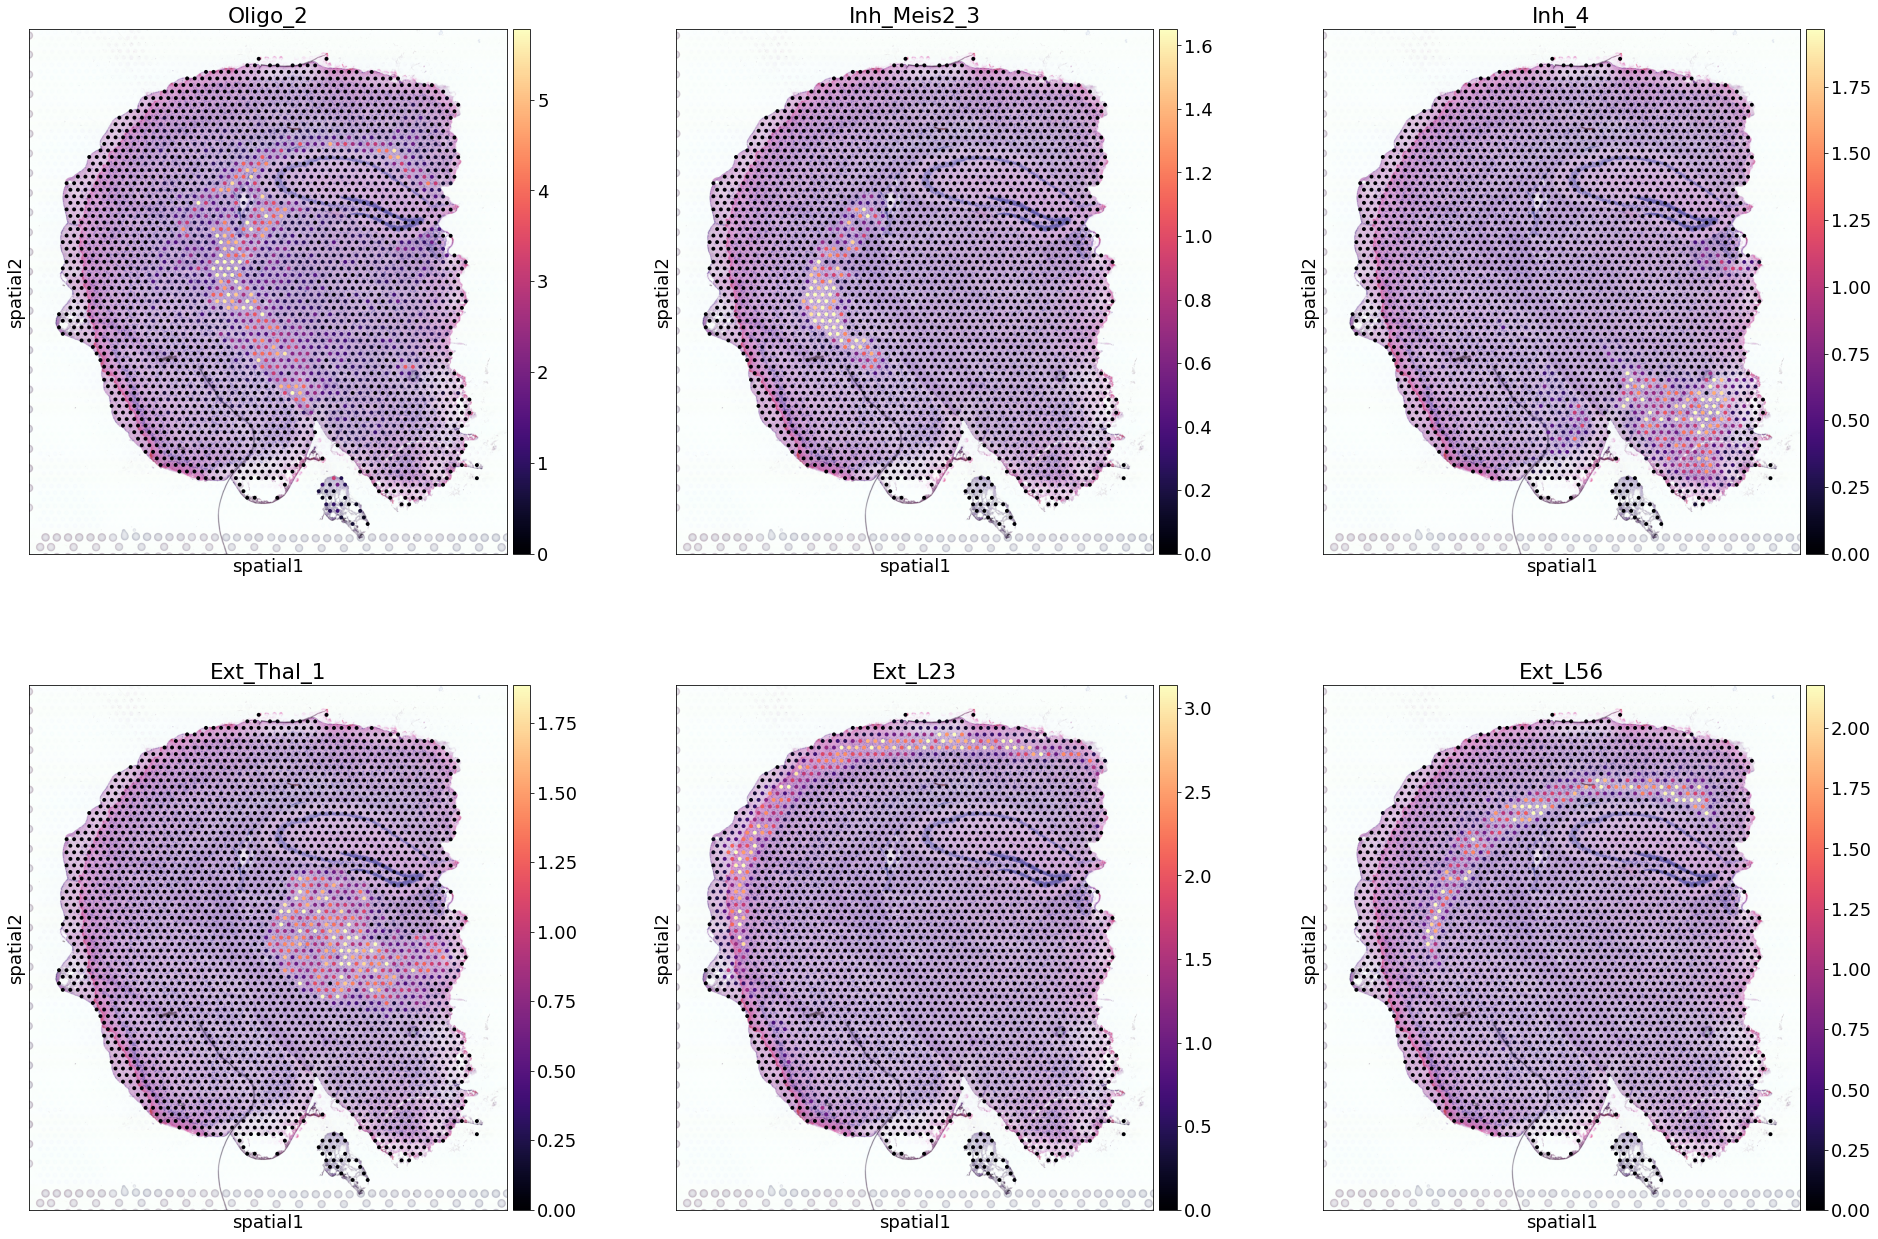

In [8]:
sel_clust = ['Oligo_2', 'Inh_Meis2_3', 'Inh_4', 'Ext_Thal_1', 'Ext_L23', 'Ext_L56']
sel_clust_col = ['q05_spot_factors' + str(i) for i in sel_clust]

# select one section correctly subsetting histology image data
slide = select_slide(adata_vis, 'ST8059048')

# plot with nice names
with mpl.rc_context({'figure.figsize': (10, 10), "font.size": 18}):
    # add slide.obs with nice names
    slide.obs[sel_clust] = (slide.obs[sel_clust_col])
    
    sc.pl.spatial(slide, cmap='magma',
                  color=sel_clust[0:6], # limit size in this notebook
                  ncols=3, 
                  size=0.8, img_key='hires', 
                  alpha_img=0.9,
                  vmin=0, vmax='p99.2'
                 )

## 3. Identifying tissue regions by clustering <a name="3.-Identifying-tissue-regions-by-clustering"></a>

We identify tissue regions that differ in their cell composition by clustering locations using cell abundance estimated by cell2location. 

We find tissue regions by clustering Visium spots using estimated cell abundance each cell type. We constuct a K-nearest neigbour (KNN) graph representing similarity of locations in estimated cell abundance and then apply Leiden clustering. The number of KNN neighbours should be adapted to size of dataset and the size of anatomically defined regions (e.i. hippocampus regions are rather small so could be masked by large `n_neighbors`). This can be done for a range KNN neighbours and Leiden clustering resolutions until a clustering matching the anatomical structure of the tissue is obtained. 

The clustering is done jointly across all Visium sections / batches, hence the region identities are directly comparable. When there are strong technical effects between multiple batches (not the case here) `sc.external.pp.bbknn` can be used to account for those effects during the KNN construction.

The resulting clusters are saved in `adata_vis.obs['region_cluster']`.

In [9]:
sample_type = 'q05_nUMI_factors'
col_ind = [sample_type in i for i in adata_vis.obs.columns.tolist()]
adata_vis.obsm[sample_type] = adata_vis.obs.loc[:,col_ind].values

# compute KNN using the cell2location output
sc.pp.neighbors(adata_vis, use_rep=sample_type,
                n_neighbors = 20)

# Cluster spots into regions using scanpy
sc.tl.leiden(adata_vis, resolution=1)

# add region as categorical variable
adata_vis.obs["region_cluster"] = adata_vis.obs["leiden"]
adata_vis.obs["region_cluster"] =  adata_vis.obs["region_cluster"].astype("category")

#### Visualise the regions in UMAP based on cell abundances and in 2D

Here we use the same KNN graph representing similarity locations in terms of cell abundance to perform UMAP projection of all locations. We can see that cell2location successfully integrated the 2 sections. You can see that the regions with analogous position in the cortex (2D below) are composed out of spots coming from both samples (e.g. region cluster 14, 16, 0 - cortical layers L4, L5 and L6). 

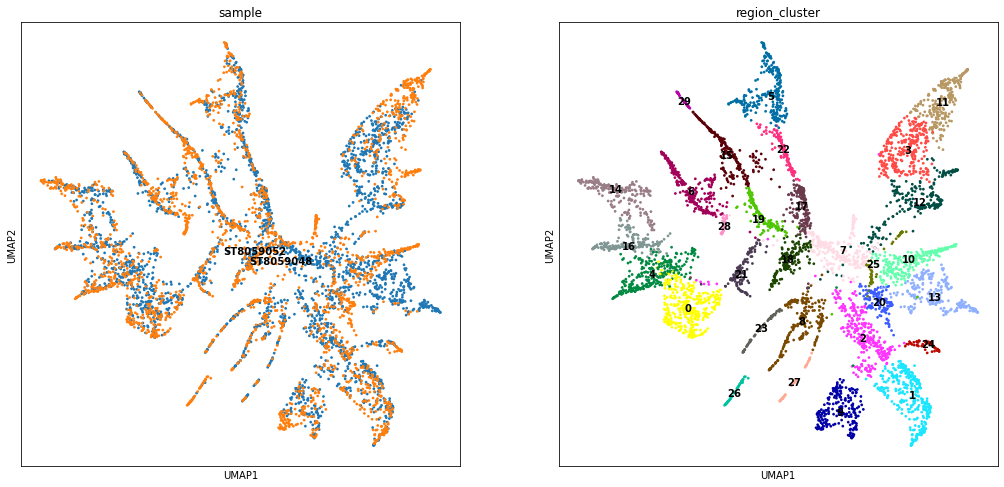

In [10]:
sc.tl.umap(adata_vis, min_dist = 0.3, spread = 1)

with mpl.rc_context({'figure.figsize': (8, 8)}):
    sc.pl.umap(adata_vis, color=['sample', 'region_cluster'], size=30,
               color_map = 'RdPu', ncols = 2, legend_loc='on data',
               legend_fontsize=10)

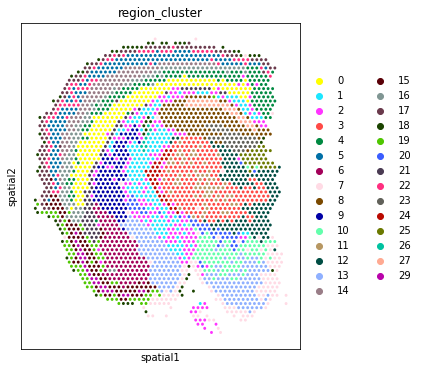

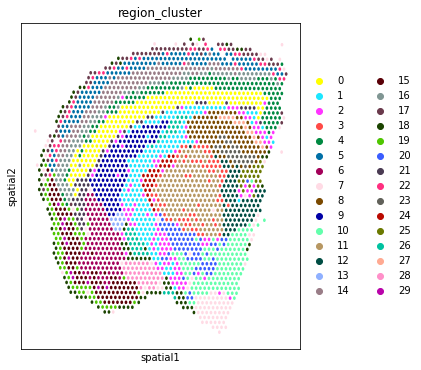

In [11]:
# Plot the region identity of each location in 2D space
# Plotting UMAP of integrated datasets before 2D plots of separate sections ensures 
# consistency of colour scheme via `adata_vis.uns['region_cluster_colors']`.
with mpl.rc_context({'figure.figsize': (5, 6)}):
    sc.pl.spatial(adata_vis[adata_vis.obs["sample"]=="ST8059048"], 
                  color=["region_cluster"], img_key=None
                );
    sc.pl.spatial(adata_vis[adata_vis.obs["sample"]=="ST8059052"], 
                  color=["region_cluster"], img_key=None
                )

#### Export regions for import to 10X Loupe Browser

Our region maps can be visualised over the histology image and explored interactively using the 10X Loupe Browser (please refer to 10X website for instructions).

In [12]:
# save maps for each sample separately
sam = np.array(adata_vis.obs['sample'])
for i in np.unique(sam):
    
    s1 = adata_vis.obs[['region_cluster']]
    s1 = s1.loc[sam == i]
    s1.index = [x[10:] for x in s1.index]
    s1.index.name = 'Barcode'
    
    s1.to_csv(results_folder +r['run_name']+'/region_cluster29_' + i + '.csv')

## 4. Identify groups of co-located cell types using matrix factorisation <a name="5.-Identify-groups-of-co-located-cell-types-using-matrix-factorisation"></a>

Here, we use estimated cell abundances as an input to non-negative matrix factorisation to identify groups of co-located cell types $R$, which can be interpreted as cellular compartments or tissue zones. See [paper section 4](https://www.biorxiv.org/content/10.1101/2020.11.15.378125v1) and Supplemenary Methods for details. Intuitively, we hypothesise that cell interactions can drive linear dependencies in cell type abundance, which can be estimated via NMF [Supplemenary Methods section 4.2](https://github.com/vitkl/cell2location_paper/blob/master/paper/Supplementary_Methods_cell2location.pdf). In addition, we observed that tissues with a high degree of spatial interlacing of cellular comparments such as the human lymph nodes are better described by NMF that by discrete clustering (see [paper Fig S16](https://www.biorxiv.org/content/10.1101/2020.11.15.378125v1.supplementary-material))


<div class="alert alert-block alert-primary">
<b>Tip</b>
If you want to find a few most disctinct cellular compartments, use a small number of factors.   
If you want to find very strong co-location signal and assume that most cell types don't co-locate, use a lot of factors (> 30 - used here).
In practice, it is better to train NMF for a range of factors $R={5, .., 30}$ and select $R$ as a balance between capturing fine tissue zones and splitting known compartments
</div>

Below we show how to perform this analysis. First, we initialise this model and train it several times to evaluate consitency of identified compartments.

In [13]:
# number of cell type combinations - educated guess assuming that most cell types don't co-locate
n_fact = int(30)

# extract cell abundance from cell2location
X_data = adata_vis.uns['mod']['post_sample_q05']['spot_factors']

import cell2location.models as c2l
# create model class
mod_sk = c2l.CoLocatedGroupsSklearnNMF(n_fact, X_data, 
        n_iter = 10000,
        verbose = True,
        var_names=adata_vis.uns['mod']['fact_names'],
        obs_names=adata_vis.obs_names,
        fact_names=['fact_' + str(i) for i in range(n_fact)],
        sample_id=adata_vis.obs['sample'],
        init='random', random_state=0,
        nmf_kwd_args={'tol':0.0001})

# train 5 times to evaluate stability
mod_sk.fit(n=5, n_type='restart') 

init_1 - iterations until convergence: 806
init_2 - iterations until convergence: 984
init_3 - iterations until convergence: 987
init_4 - iterations until convergence: 997
init_5 - iterations until convergence: 1016


Now, let's examine a few diagnostic plots. First, you can see that most cell type combinations are consistent between training restarts of this model (diagonal with high correlation). The first restart is used (y-axis) so we can take a note that factors 21, 23, 25 (0-based) is not very robust.

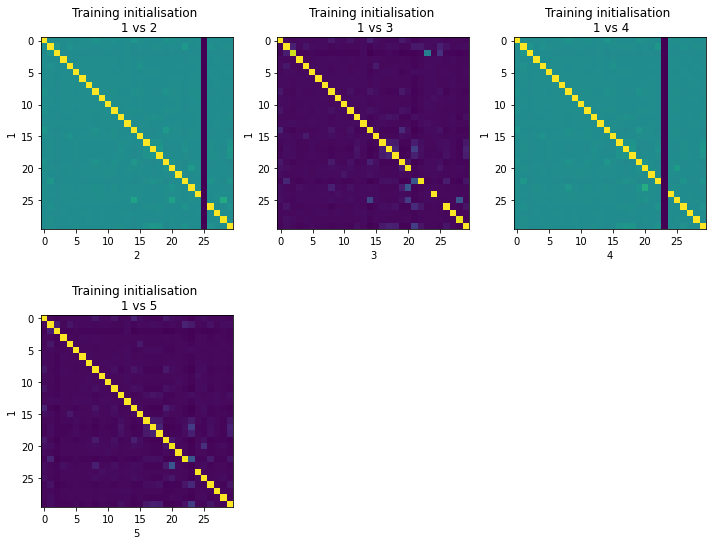

In [14]:
## Do some diagnostics
# evaluate stability by comparing trainin restarts

with mpl.rc_context({'figure.figsize': (10, 8)}):
    mod_sk.evaluate_stability('cell_type_factors', align=True)

Next we evaluate the accuracy of NMF the cell type groups at explaining the abundace of individual cell types. You should see a diagonal 2D histogram comparing the input cell density data (X-axis) and imputed values from the model (Y-axis). Here we a few minor deviations for low abundance cell types.

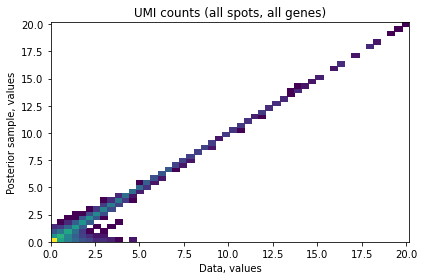

In [15]:
# evaluate accuracy of the model
mod_sk.compute_expected()
mod_sk.plot_posterior_mu_vs_data()

Finally, let's investigate the composition of each NMF cell type group. We use our model to compute the relative contribution of NMF groups to each cell type (`'cell_type_fractions'` e.g. 45% of cell abundance of `Astro_THAL_hab` can be explained by fact_10). 
Note: factors are exchangeable so while you find consistent factors, each model training restart will output those factors in a different order.

Here we export these parameters from the model into `adata_vis.uns['mod_sklearn']` in the spatial anndata object, and print the cell types most specific to each NMF group:

In [16]:
# extract parameters into DataFrames
mod_sk.sample2df(node_name='nUMI_factors', ct_node_name = 'cell_type_factors')

# export results to scanpy object
adata_vis = mod_sk.annotate_adata(adata_vis) # as columns to .obs
adata_vis = mod_sk.export2adata(adata_vis, slot_name='mod_sklearn') # as a slot in .uns

# print the fraction of cells of each type located to each combination
mod_sk.print_gene_loadings(loadings_attr='cell_type_fractions',
                         gene_fact_name='cell_type_fractions')

top-1                 top-2  \
mean_cell_type_factorsfact_0    Ext_Hpc_DG1: 1.0            Nb_1: 0.52   
mean_cell_type_factorsfact_1          Inh_2: 1.0           Inh_5: 0.72   
mean_cell_type_factorsfact_2        Ext_Pir: 1.0   Astro_AMY_CTX: 0.12   
mean_cell_type_factorsfact_3   Ext_Hpc_CA1: 0.99      Astro_HPC: 0.063   
mean_cell_type_factorsfact_4   Ext_Hpc_CA3: 0.99      Astro_STR: 0.067   
mean_cell_type_factorsfact_5      Astro_WM: 0.93            Nb_2: 0.82   
mean_cell_type_factorsfact_6      Ext_Amy_2: 1.0       Astro_AMY: 0.21   
mean_cell_type_factorsfact_7        LowQ_1: 0.99           Nb_2: 0.038   
mean_cell_type_factorsfact_8       Ext_L23: 0.99       Inh_Lamp5: 0.19   
mean_cell_type_factorsfact_9       Ext_L56: 0.92           Ext_L6: 0.7   
mean_cell_type_factorsfact_10         Inh_6: 1.0  Astro_THAL_hab: 0.45   
mean_cell_type_factorsfact_11     Ext_Unk_3: 1.0  Astro_THAL_med: 0.17   
mean_cell_type_factorsfact_12  Inh_Meis2_3: 0.98     Inh_Meis2_1: 0.24   
mean_cell_type_factorsfact_13      Ext_L25: 0.95       Astro_CTX: 0.16   
mean_cell_type_factorsfact_14  Ext_Hpc_DG2: 0.99       Astro_HPC: 0.34   
mean_cell_type_factorsfact_15   Ext_Thal_1: 0.99  Astro_THAL_lat: 0.35   
mean_cell_type_factorsfact_16     Ext_Unk_2: 1.0      Astro_HYPO: 0.11   
mean_cell_type_factorsfact_17    Ext_Thal_2: 1.0  Astro_THAL_med: 0.32   
mean_cell_type_factorsfact_18        Inh_1: 0.99      Inh_Meis2_1: 0.4   
mean_cell_type_factorsfact_19  Inh_Meis2_4: 0.99  Astro_THAL_lat: 0.13   
mean_cell_type_factorsfact_20      Ext_L6B: 0.99        Ext_L5_3: 0.86   
mean_cell_type_factorsfact_21     Ext_Amy_1: 1.0        Astro_AMY: 0.4   
mean_cell_type_factorsfact_22   Ext_ClauPyr: 1.0        Ext_L56: 0.063   
mean_cell_type_factorsfact_23      Oligo_2: 0.88          Oligo_1: 0.3   
mean_cell_type_factorsfact_24    Inh_Pvalb: 0.95         Ext_Med: 0.49   
mean_cell_type_factorsfact_25  Ext_Hpc_CA2: 0.99        Inh_Vip: 0.047   
mean_cell_type_factorsfact_26  Inh_Meis2_2: 0.98       Astro_STR: 0.18   
mean_cell_type_factorsfact_27      Ext_L5_2: 1.0          LowQ_2: 0.52   
mean_cell_type_factorsfact_28     Ext_L5_1: 0.99           Unk_1: 0.15   
mean_cell_type_factorsfact_29         Inh_4: 1.0           Inh_3: 0.42   

                                               top-3                  top-4  \
mean_cell_type_factorsfact_0        Astro_HPC: 0.095         Inh_Vip: 0.056   
mean_cell_type_factorsfact_1             Inh_3: 0.39   Astro_THAL_lat: 0.37   
mean_cell_type_factorsfact_2           Inh_Vip: 0.07         Inh_Sst: 0.065   
mean_cell_type_factorsfact_3        Astro_STR: 0.043         Inh_Vip: 0.028   
mean_cell_type_factorsfact_4        Astro_HPC: 0.046            Nb_1: 0.034   
mean_cell_type_factorsfact_5             OPC_2: 0.36        Ext_Unk_1: 0.33   
mean_cell_type_factorsfact_6     Astro_AMY_CTX: 0.17      Inh_Meis2_1: 0.16   
mean_cell_type_factorsfact_7             Endo: 0.023           Unk_2: 0.021   
mean_cell_type_factorsfact_8           Inh_Vip: 0.17          Ext_Med: 0.16   
mean_cell_type_factorsfact_9             Unk_1: 0.12         Inh_Lamp5: 0.1   
mean_cell_type_factorsfact_10           Unk_2: 0.041           OPC_2: 0.035   
mean_cell_type_factorsfact_11       Astro_HYPO: 0.11  Astro_THAL_hab: 0.052   
mean_cell_type_factorsfact_12        Astro_AMY: 0.11        Astro_STR: 0.11   
mean_cell_type_factorsfact_13       Inh_Lamp5: 0.068            Endo: 0.057   
mean_cell_type_factorsfact_14             Nb_1: 0.11       Ext_Unk_1: 0.044   
mean_cell_type_factorsfact_15   Astro_THAL_med: 0.22            Endo: 0.053   
mean_cell_type_factorsfact_16    Astro_THAL_med: 0.1   Astro_THAL_lat: 0.08   
mean_cell_type_factorsfact_17       Astro_HYPO: 0.18            Unk_2: 0.13   
mean_cell_type_factorsfact_18        Astro_AMY: 0.13       Ext_Unk_1: 0.086   
mean_cell_type_factorsfact_19  Astro_THAL_hab: 0.086            Endo: 0.037   
mean_cell_type_factorsfact_20        Astro_STR: 0.12         Inh_Vip: 0.079   
mean_cell_

A convenient way to explore which cell types show co-location signals is by using a heatmap. Here, we note that most factors correspond to a single neuron type (e.g. Ext_Pir), however, many neurone types are associated with corresponding regional astrocyte subtypes, such as 

1. fact_10 - Astro_THAL_hab and Inh_6 neurones
2. fact_21 - Astro_AMY and Ext_Amy_1 neurones
3. fact_14 - Astro_HPC and Ext_Hpc_DG2 neurones

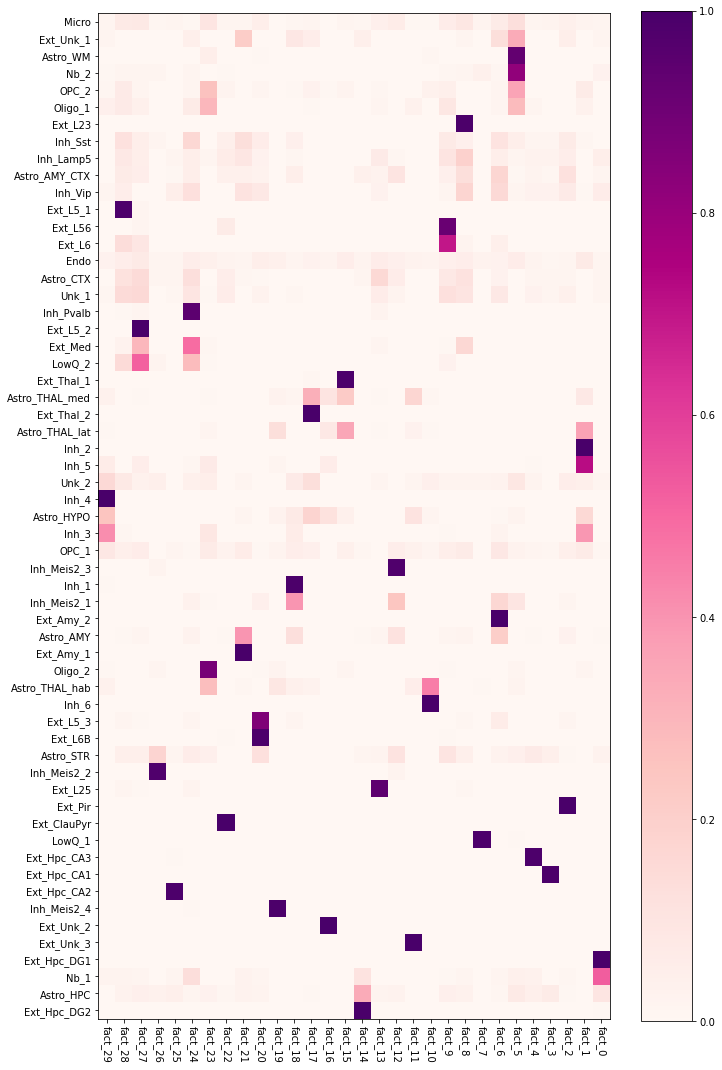

In [17]:
# make nice names
from re import sub
mod_sk.cell_type_fractions.columns = [sub('mean_cell_type_factors', '', i) 
                                      for i in mod_sk.cell_type_fractions.columns]

# plot co-occuring cell type combinations
mod_sk.plot_gene_loadings(mod_sk.var_names_read, mod_sk.var_names_read,
                        fact_filt=mod_sk.fact_filt,
                        loadings_attr='cell_type_fractions',
                        gene_fact_name='cell_type_fractions',
                        cmap='RdPu', figsize=[10, 15])

Finally, we need to examine the abundance of each cell type group across locations:

Trying to set attribute `.uns` of view, copying.


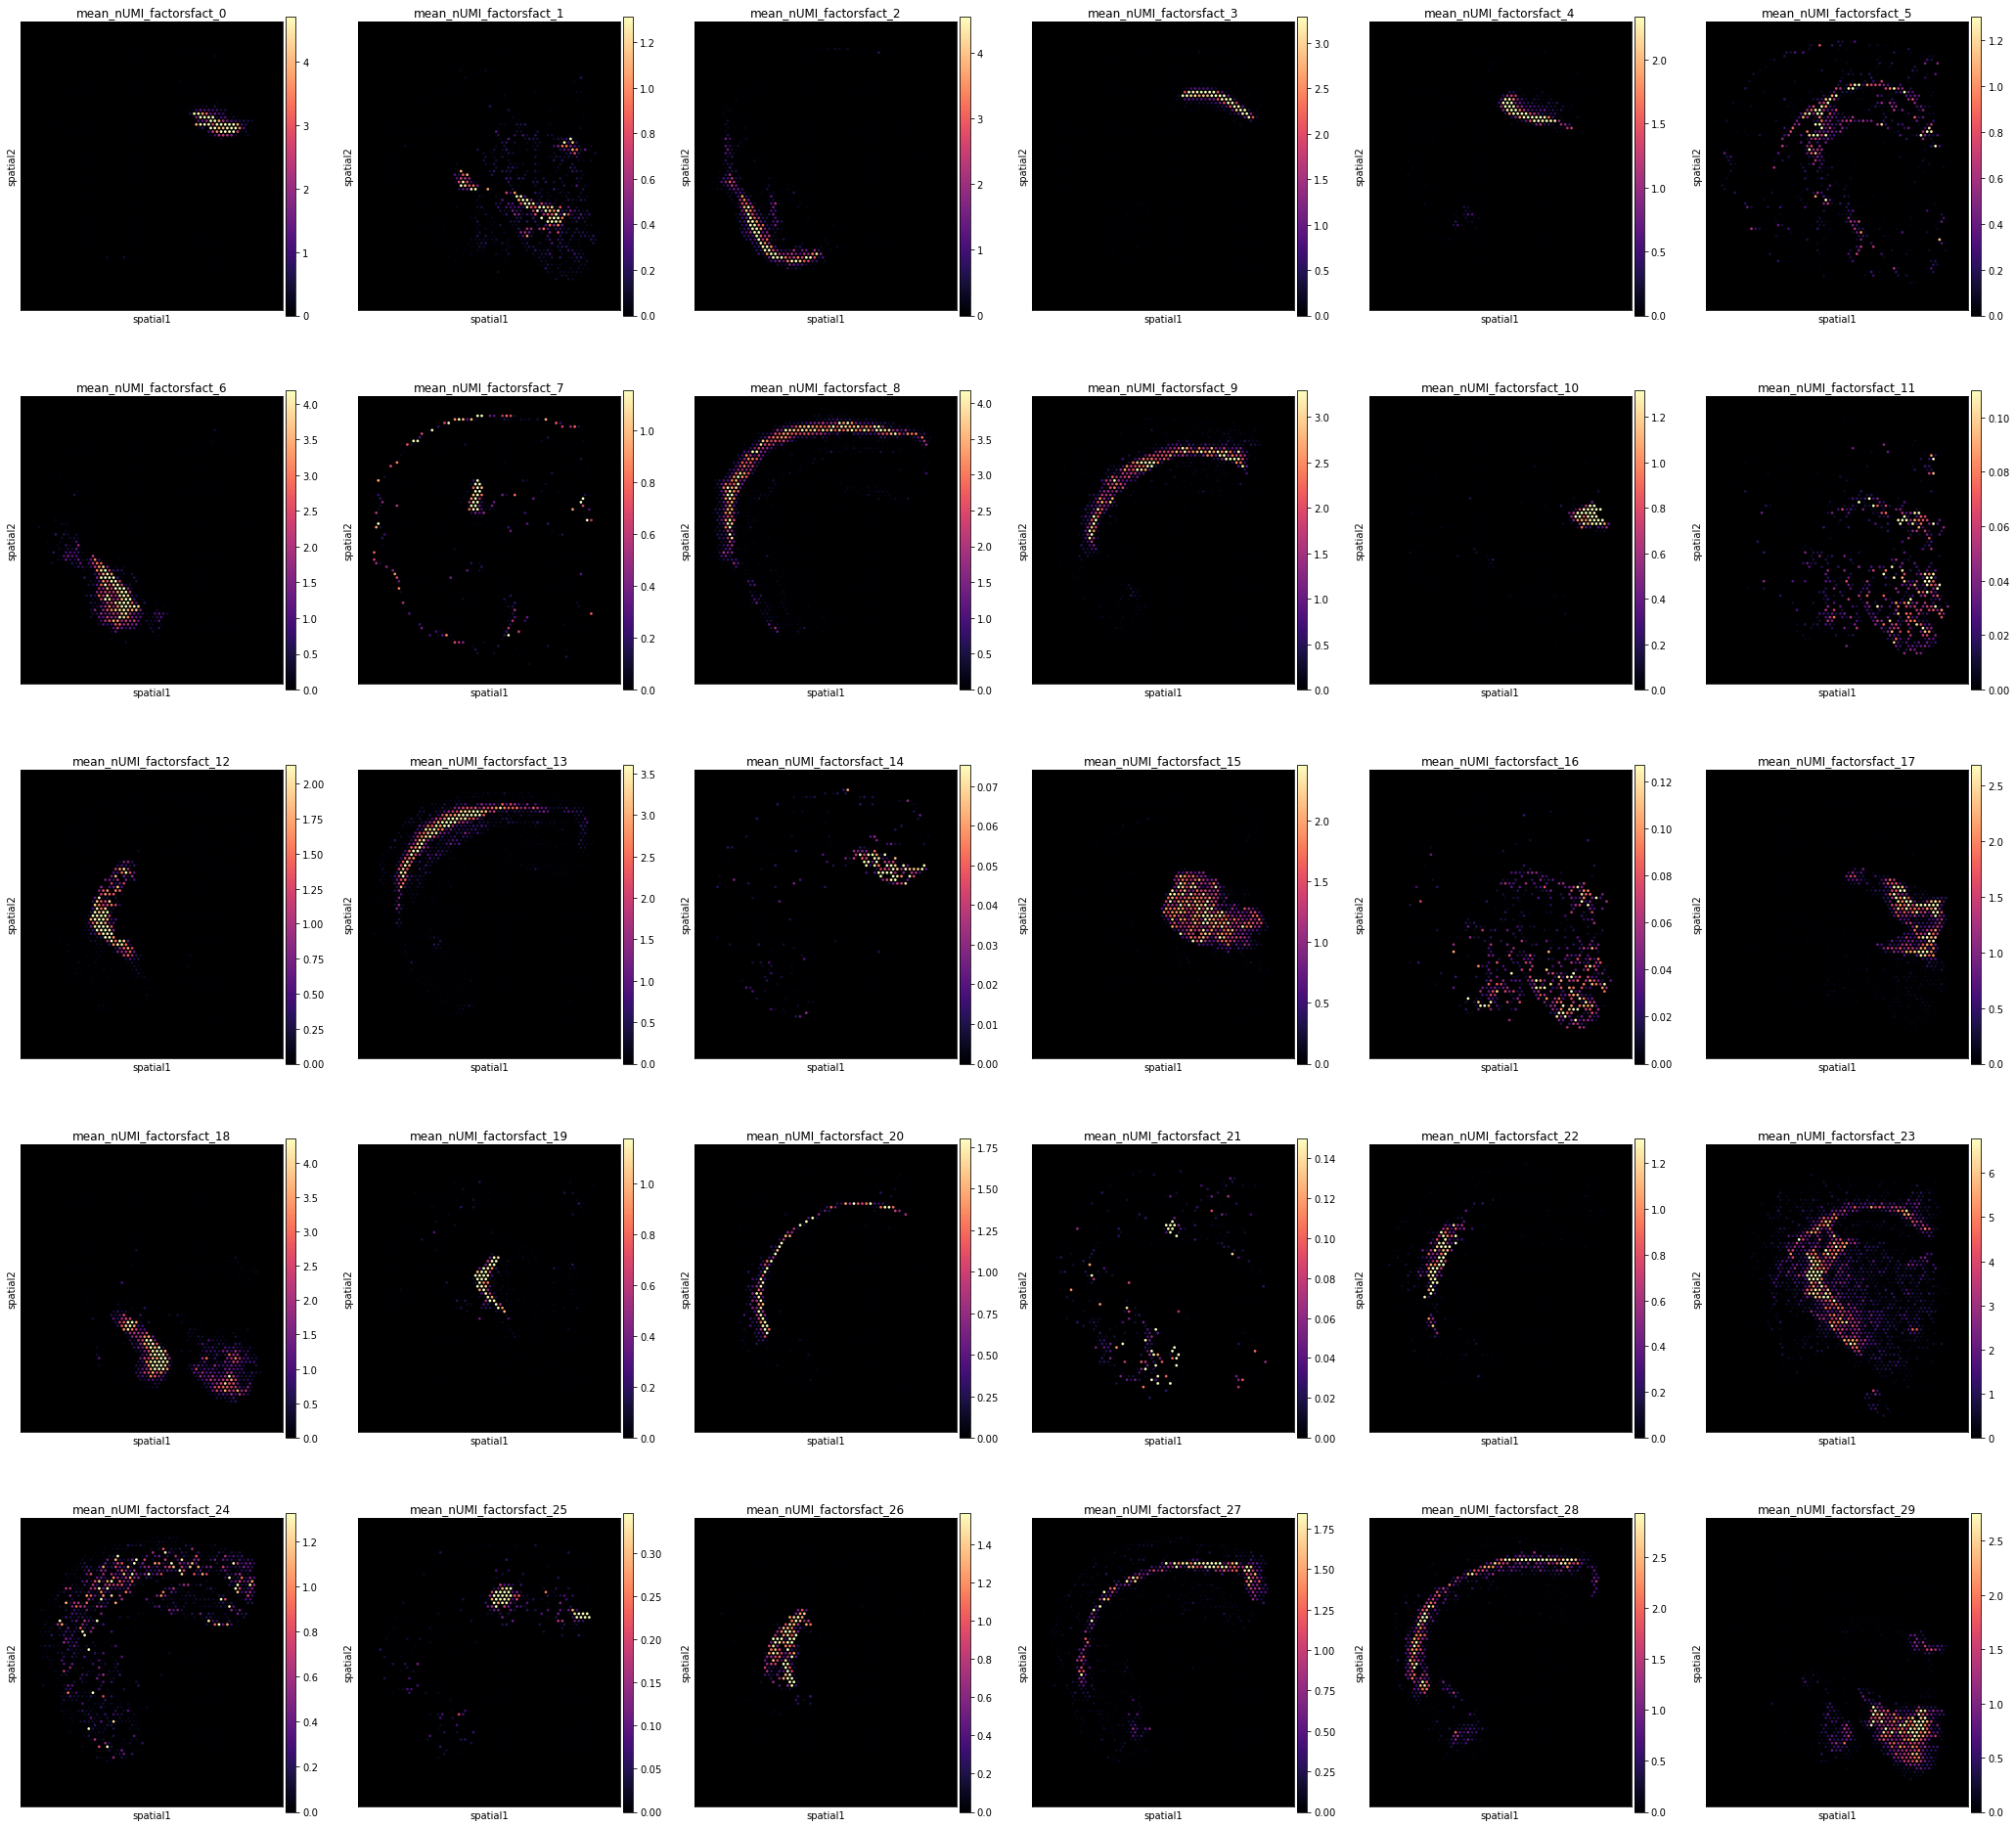

In [18]:
# plot cell density in each combination
with mpl.rc_context({'figure.figsize': (5, 6), 'axes.facecolor': 'black'}):
    
    # select one section correctly subsetting histology image data
    slide = select_slide(adata_vis, 'ST8059048')
    
    sc.pl.spatial(slide,
                  cmap='magma',
                  color=mod_sk.location_factors_df.columns,
                  ncols=6, 
                  size=1, img_key='hires', 
                  alpha_img=0,
                  vmin=0, vmax='p99.2'
                 )

Now we save the NMF model object to work with later (rememeber, every time you train the model, factors with the same composition will have a different order):

In [20]:
# save co-location models object
def pickle_model(mod, path, file_suffix=''):
    file = path + 'model_' + str(mod.__class__.__name__) + '_' + str(mod.n_fact) + '_' + file_suffix + ".p"
    pickle.dump({'mod': mod, 'fact_names': mod.fact_names}, file = open(file, "wb"))
    print(file)
    
pickle_model(mod_sk, results_folder +r['run_name'] + '/', file_suffix='')

./results/mouse_brain_snrna/LocationModelLinearDependentWMultiExperiment_2experiments_59clusters_5563locations_4006genes/model_CoLocatedGroupsSklearnNMF_30_.p


### It is often useful to train NMF for a range of factors $R$ to select most meaningful cell type groups

To aid this analysis, we wrapped the analysis shown above into a pipeline that automates training the NMF model with varying number of factors (including export of the same plots and data as shown above).

```python
from cell2location import run_colocation
res_dict, adata_vis = run_colocation(
                   adata_vis, model_name='CoLocatedGroupsSklearnNMF',
                   verbose=False, return_all=True,
    
                   train_args={
                    'n_fact': np.arange(10, 40), # IMPORTANT: range of number of factors (10-40 here)
                    'n_iter': 20000, # maximum number of training iterations
                       
                    'sample_name_col': 'sample', # columns in adata_vis.obs that identifies sample
                       
                    'mode': 'normal',
                    'n_type': 'restart', 'n_restarts': 5 # number of training restarts
                   },
    
                   model_kwargs={'init': 'random', 'random_state': 0, 'nmf_kwd_args': {'tol': 0.00001}},
    
                   posterior_args={},
                   export_args={'path': results_folder + 'std_model/'+r['run_name']+'/CoLocatedComb/',
                                'run_name_suffix': ''}) 
```

## Export results

Save resulting anndata object that now include region clustering and co-located cell type groups.

In [21]:
adata_file = results_folder +r['run_name']+'/sp_with_clusters.h5ad'
adata_vis.write(adata_file)
adata_file

'./results/mouse_brain_snrna/LocationModelLinearDependentWMultiExperiment_2experiments_59clusters_5563locations_4006genes/sp_with_clusters.h5ad'

Modules and their versions used for this analysis

In [22]:
import sys
for module in sys.modules:
    try:
        print(module,sys.modules[module].__version__)
    except:
        try:
            if  type(sys.modules[module].version) is str:
                print(module,sys.modules[module].version)
            else:
                print(module,sys.modules[module].version())
        except:
            try:
                print(module,sys.modules[module].VERSION)
            except:
                pass


sys 3.7.8 | packaged by conda-forge | (default, Jul 31 2020, 02:25:08) 
[GCC 7.5.0]
ipykernel 5.3.4
ipykernel._version 5.3.4
json 2.0.9
re 2.2.1
IPython 7.19.0
IPython.core.release 7.19.0
logging 0.5.1.2
zlib 1.0
traitlets 5.0.5
traitlets._version 5.0.5
argparse 1.1
ipython_genutils 0.2.0
ipython_genutils._version 0.2.0
platform 1.0.8
IPython.core.crashhandler 7.19.0
pygments 2.7.2
pexpect 4.8.0
ptyprocess 0.6.0
decorator 4.4.2
pickleshare 0.7.5
backcall 0.2.0
sqlite3 2.6.0
sqlite3.dbapi2 2.6.0
_sqlite3 2.6.0
prompt_toolkit 3.0.8
wcwidth 0.2.5
jedi 0.17.2
parso 0.7.1
colorama 0.4.4
ctypes 1.1.0
_ctypes 1.1.0
urllib.request 3.7
jupyter_client 6.1.7
jupyter_client._version 6.1.7
zmq 20.0.0
zmq.backend.cython 40303
zmq.backend.cython.constants 40303
zmq.sugar 20.0.0
zmq.sugar.constants 40303
zmq.sugar.version 20.0.0
jupyter_core 4.6.3
jupyter_core.version 4.6.3
distutils 3.7.8
tornado 6.1
_curses b'2.2'
dateutil 2.8.1
dateutil._version 2.8.1
six 1.15.0
decimal 1.70
_decimal 1.70
scanpy 1.